In [91]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

from scipy.stats import entropy
entropy_fix = np.log2(np.e)

In [92]:
def running_mean(x, N=5):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [93]:
month_table = pd.read_csv('MORI_superissues_table.csv', index_col=0)

month_table.head()

,Macroeconomic Policy,Social Policy,Environment and Natural Resources,Foreign Affairs and Defense,"Law, Order, and Civil Rights",month,year,date
29,130.5,19.0,0.0,37.0,12.25,Jan-85,1985.0,1985-01-01
30,141.5,29.0,0.0,34.0,10.25,Feb-85,1985.0,1985-02-01
31,124.5,30.0,0.0,30.0,15.25,Mar-85,1985.0,1985-03-01
32,117.5,33.0,0.0,29.0,16.25,Apr-85,1985.0,1985-04-01
33,113.5,31.0,0.0,29.0,19.25,May-85,1985.0,1985-05-01


In [94]:
# make the moving average month table
N = 5

new_df_dic = {}
for key in month_table.keys()[:-3]:
    new_df_dic[key] = running_mean(month_table[key].values, N=N)

new_df_dic['month'] = month_table['month'].values[int((N-1)/2):-int((N-1)/2)]
new_df_dic['year']  = month_table['year'].values[int((N-1)/2):-int((N-1)/2)]

table_moving_average = pd.DataFrame(new_df_dic)
table_moving_average.head()

,Environment and Natural Resources,Foreign Affairs and Defense,"Law, Order, and Civil Rights",Macroeconomic Policy,Social Policy,month,year
0,0.0,31.8,14.65,125.5,28.4,Mar-85,1985.0
1,0.0,29.8,17.45,122.3,30.8,Apr-85,1985.0
2,0.0,28.4,18.85,114.1,30.0,May-85,1985.0
3,0.0,28.0,20.05,110.9,30.4,Jun-85,1985.0
4,0.0,27.8,23.05,107.9,29.4,Jul-85,1985.0


In [95]:
table = table_moving_average

all_entropies = []
n_issues = []

for index, row in table.iterrows():
    topic_array = np.array(row.values[:-2],dtype=np.float64)
    all_entropies += [ entropy(topic_array)*entropy_fix ]
    n_issues      += [ sum(row.values[:-2]>0) ]

all_entropies = np.array(all_entropies)
n_issues      = np.array(n_issues)

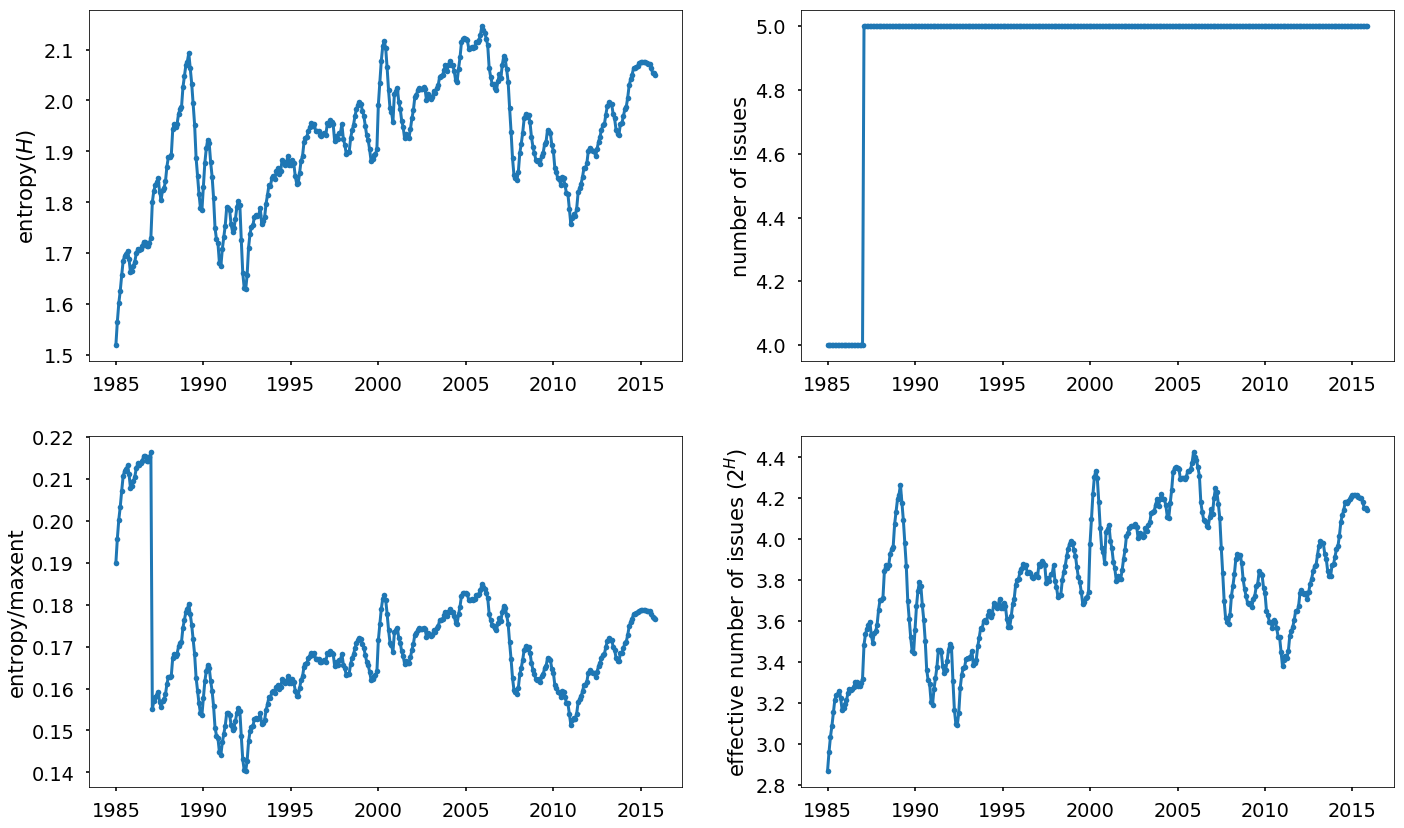

In [96]:
sns.set_context('poster', rc={"lines.linewidth": 3}, font_scale=1.2)

fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1] ]

ys = [ [ s                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ n                if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ s/(n*np.log2(n)) if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ],
       [ 2**s             if n>0 else -np.inf for s,n in zip(all_entropies, n_issues) ]
     ]


xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ylabels = ['entropy($H$)', 'number of issues', 'entropy/maxent', r'effective number of issues ($2^H$)']
for ax,y,ylabel in zip(axs,ys,ylabels):
    ax.plot(table.index, y, '.-')
    ax.set_ylabel(ylabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
plt.tight_layout()
plt.savefig('images/superissues-entropy-months.png', dpi=200)
plt.show()

In [98]:
from numpy.linalg import norm
from scipy.spatial.distance import hamming
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score

def rel_entr(p, q, ep=0.01, fill_all_zeros=True):
    if fill_all_zeros is True:
        P = [ i if i > 0 else ep for i in p ]
        Q = [ i if i > 0 else ep for i in q ]
        return entropy(P,Q)*entropy_fix
    
    else:
        P = []
        Q = []
        for i in range(len(p)):
            
            if p[i] == 0:
                if q[i] != 0:
                    P += [ep]
                    Q += [q[i]]
                else: # q[i] == 0
                    P += [p[i]]
                    Q += [q[i]]
                    continue
                    
            else:# p[i] != 0
                if q[i] != 0:
                    P += [p[i]]
                    Q += [q[i]]
                else: # q[i] == 0
                    P += [p[i]]
                    Q += [ep]
                    
        return entropy(P,Q)*entropy_fix


def JSD(P, Q,ep=0.01, fill_all_zeros=True):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (rel_entr(_P, _M,ep=ep,fill_all_zeros=fill_all_zeros) + rel_entr(_Q, _M,ep=ep,fill_all_zeros=fill_all_zeros))


def BCD(P,Q):
    _P = np.array(P / norm(P, ord=1),dtype=np.float32)
    _Q = np.array(Q / norm(Q, ord=1),dtype=np.float32)
    BC = np.dot(np.sqrt(_P),np.sqrt(_Q))
    
    return -np.log2(BC)    


def MI(_P,_Q):
    return mutual_info_score(_P,_Q)


def novelty(p,q,metric='KL', ep=0.01, faz=True):
    
    if metric=='KL':
        return rel_entr(p,q,ep=ep,fill_all_zeros=faz)
    elif metric=='hamming':
        return hamming(p>0,q>0)
    elif metric=='euclidean':
        return euclidean(p,q)
    elif metric=='JSD':
        return JSD(p,q,ep=ep,fill_all_zeros=faz)
    elif metric=='BCD':
        return BCD(p,q)
    elif metric=='MI':
        return MI(p,q)
    else:
        return 0

## 1 - Make entropy plots

In [99]:
table = table_moving_average
issues_tplus1 = table[table.index>table.index[0]]

eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}
JSDs = {}
BCDs = {}
MIs = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    jensen = []
    bhatta = []
    mutual = []
    
    row = table.iloc[0]
    previous_topic_array = np.array(row.values[:-2])
   
    for index, row in issues_tplus1.iterrows():
        topic_array = np.array(row.values[:-2])
        y1 = previous_topic_array
        y2 = topic_array
        relative_entropies_True  += [ novelty(y2, y1, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(y2, y1, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(y2, y1, metric='hamming') ]
        jensen += [ novelty(y2, y1, metric='JSD', ep=ep, faz=False) ]
        bhatta += [ novelty(y2, y1, metric='BCD') ]
        mutual += [ novelty(y2, y1, metric='MI')/novelty(y1, y1, metric='MI') ]
        previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm
    JSDs[ep]          = jensen
    BCDs[ep]          = bhatta
    MIs[ep]           = mutual

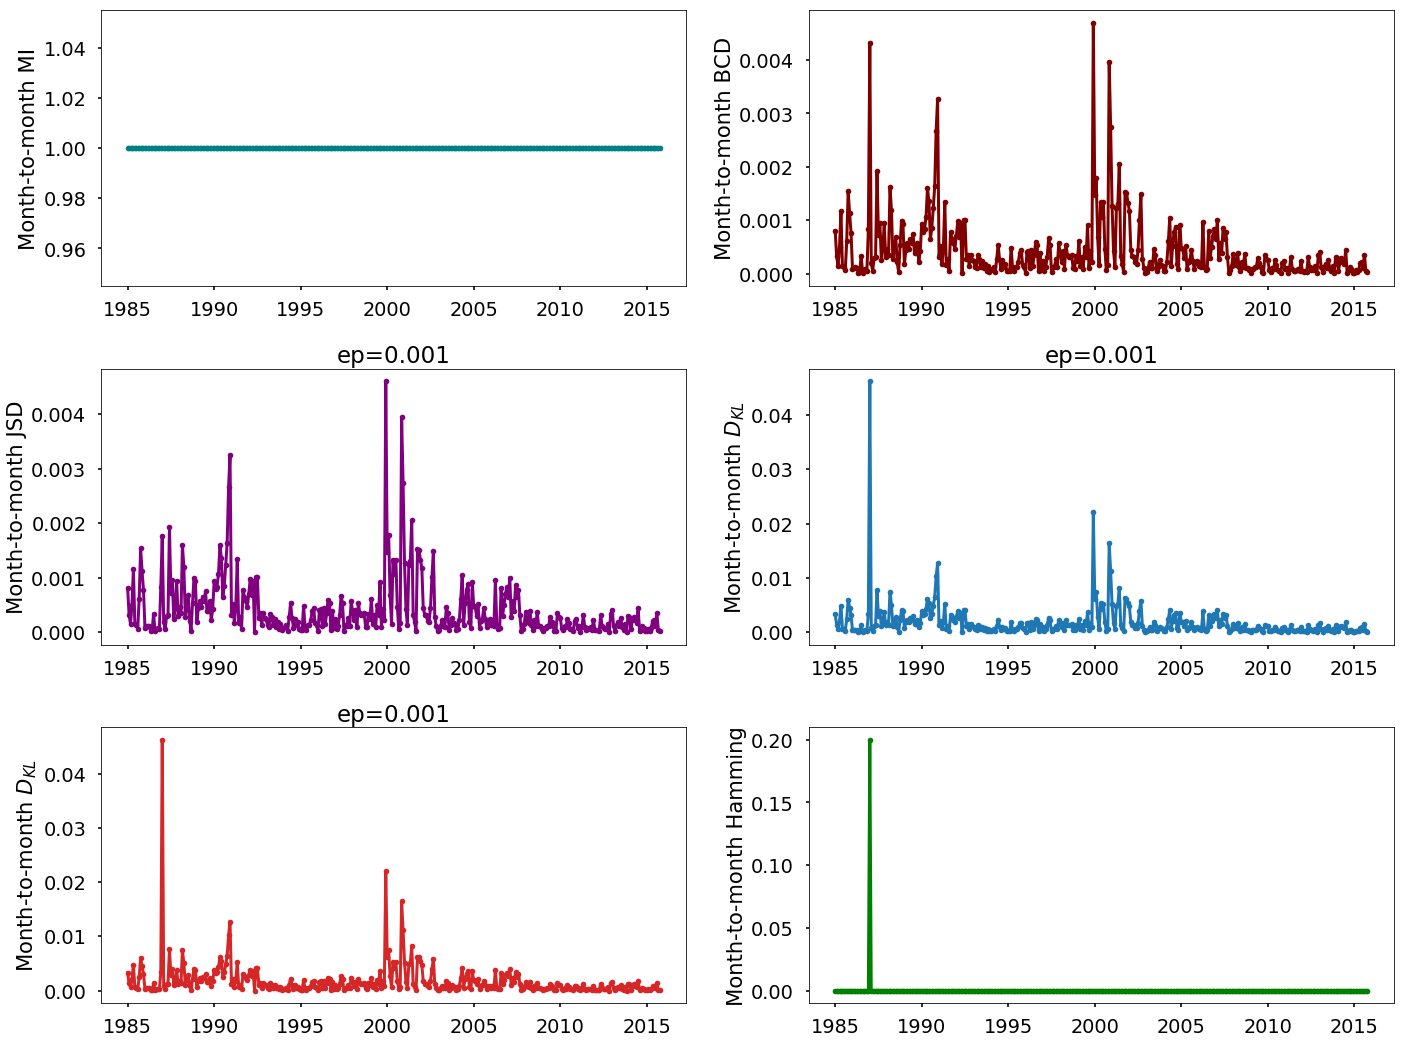

In [100]:
fig, axs = plt.subplots(3,2, figsize=(20,15))

windowsize = 1
axs = axs.reshape((axs.size,))
xticks = np.arange(windowsize,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]
indices = table.index[windowsize:]

ep = 0.001

# Normalised mutual Information
ax = axs[0]
ax.plot(indices, MIs[ep], '.-', c='teal')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month MI')

# Bhattacharya distance
ax = axs[1]
ax.plot(indices, BCDs[ep], '.-', c='maroon')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month BCD')

# JSDs:
ax = axs[2]
ax.plot(indices, JSDs[ep], '.-', c='purple')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-month JSD')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,2.5)
    
# Fill all zeros = False:
ax = axs[3]
ax.plot(indices, KLs_faz_False[ep], '.-')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-month $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,7)

# Fill all zeros = True:
ax = axs[4]
ax.plot(indices, KLs_faz_True[ep], '.-', c='#d62728')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-month $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Hamming distance
ax = axs[5]
ax.plot(indices, hammings[ep], '.-', c='g')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-month Hamming')

plt.tight_layout()
plt.savefig('images/Supertopics-divergence-month-to-month.png', dpi=300)
plt.show()

## Month-to-year comparison
Let's get the divergence metrics between a distribution and the last 12 months.

In [101]:
table = table_moving_average

windowsize = 12
issues_tplus1 = table[table.index>=table.index[windowsize]]
eps = [0.001, 0.01, 0.1, 0.2]
KLs_faz_True = {}
KLs_faz_False = {}
hammings = {}
JSDs = {}
BCDs = {}
MIs = {}

for ep in eps:
    relative_entropies_True = []
    relative_entropies_False = []
    relative_entropies_hamm = []
    jensen = []
    bhatta = []
    mutual = []
    
    row = table.iloc[0]
    #previous_topic_array = np.array(row.values[:-2])
   
    for index, row in issues_tplus1.iterrows():
        #topic_array = np.array(row.values[:-2])
        
        y1 = table.loc[index-12:index-1, ~table.columns.isin(['month','year'])].mean().values
        y2 = np.array(row.values[:-2])
        
        relative_entropies_True  += [ novelty(y2, y1, metric='KL', ep=ep, faz=True) ]
        relative_entropies_False += [ novelty(y2, y1, metric='KL', ep=ep, faz=False) ]
        relative_entropies_hamm  += [ novelty(y2, y1, metric='hamming') ]
        jensen += [ novelty(y2, y1, metric='JSD', ep=ep, faz=False) ]
        bhatta += [ novelty(y2, y1, metric='BCD') ]
        mutual += [ novelty(y2, y1, metric='MI')/novelty(y1, y1, metric='MI') ]
        #previous_topic_array = topic_array

    KLs_faz_True[ep]  = relative_entropies_True
    KLs_faz_False[ep] = relative_entropies_False
    hammings[ep]      = relative_entropies_hamm
    JSDs[ep]          = jensen
    BCDs[ep]          = bhatta
    MIs[ep]           = mutual

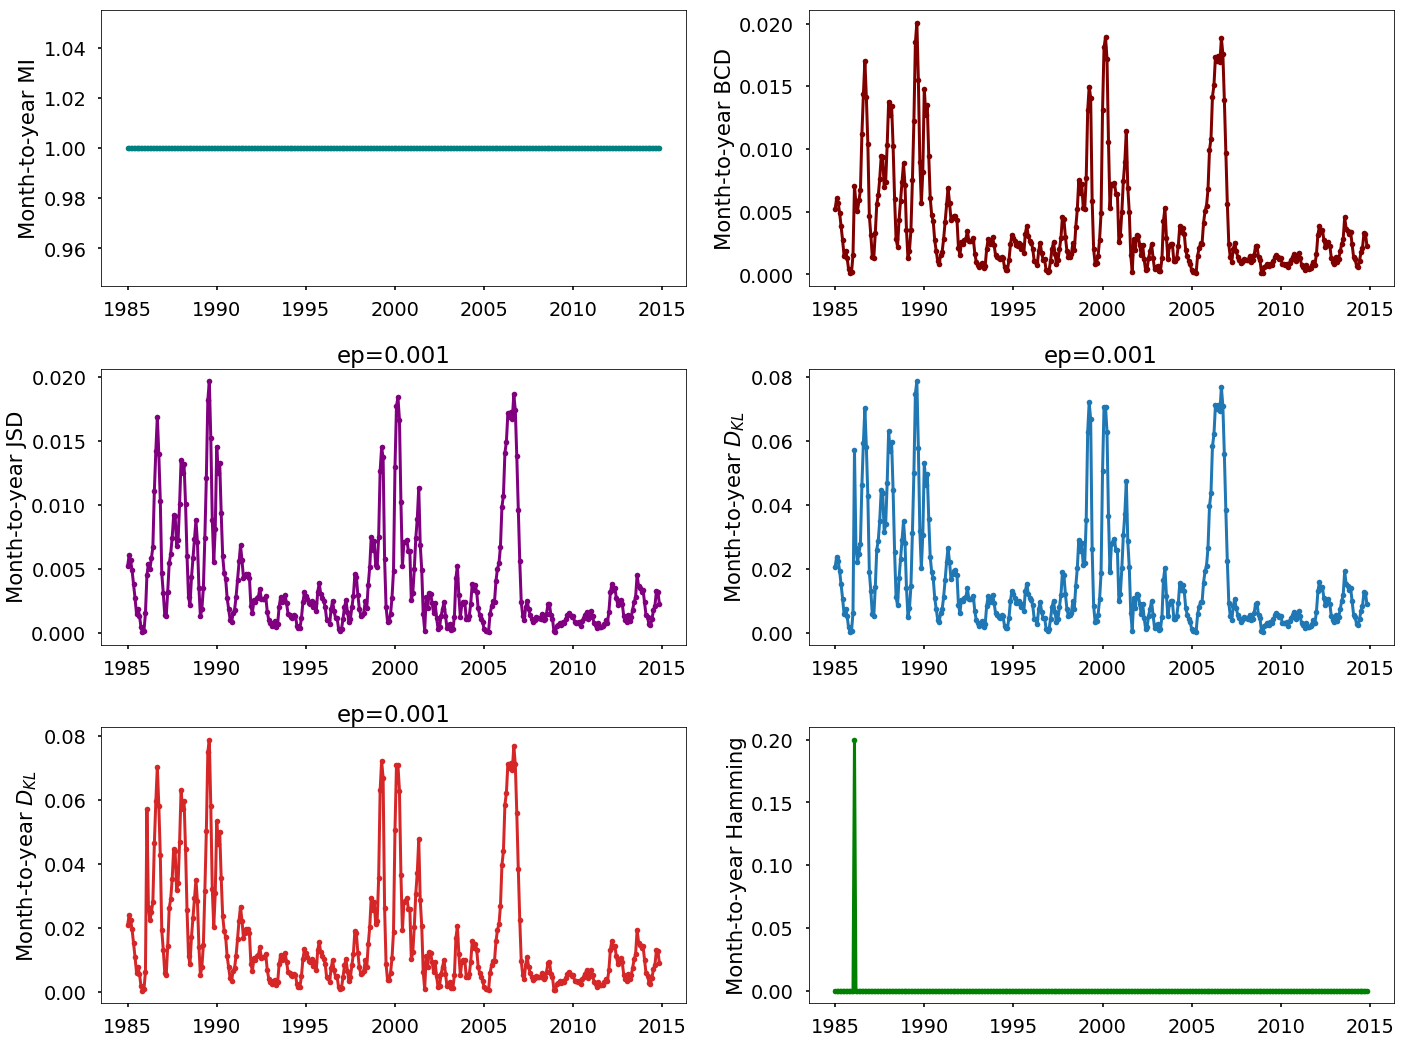

In [102]:
fig, axs = plt.subplots(3,2, figsize=(20,15))

windowsize = 12
axs = axs.reshape((axs.size,))
xticks = np.arange(windowsize,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]
indices = table.index[windowsize:]

ep = 0.001

# Normalised mutual Information
ax = axs[0]
ax.plot(indices, MIs[ep], '.-', c='teal')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year MI')

# Bhattacharya distance
ax = axs[1]
ax.plot(indices, BCDs[ep], '.-', c='maroon')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year BCD')

# JSDs:
ax = axs[2]
ax.plot(indices, JSDs[ep], '.-', c='purple')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-year JSD')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,2.5)
    
# Fill all zeros = False:
ax = axs[3]
ax.plot(indices, KLs_faz_False[ep], '.-')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-year $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
#ax.set_ylim(-0.1,7)

# Fill all zeros = True:
ax = axs[4]
ax.plot(indices, KLs_faz_True[ep], '.-', c='#d62728')
ax.set_title('ep='+str(ep))
ax.set_ylabel(r'Month-to-year $D_{KL}$')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# Hamming distance
ax = axs[5]
ax.plot(indices, hammings[ep], '.-', c='g')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'Month-to-year Hamming')

plt.tight_layout()
plt.savefig('images/Superissues-divergence-month-to-year.png', dpi=300)
plt.show()

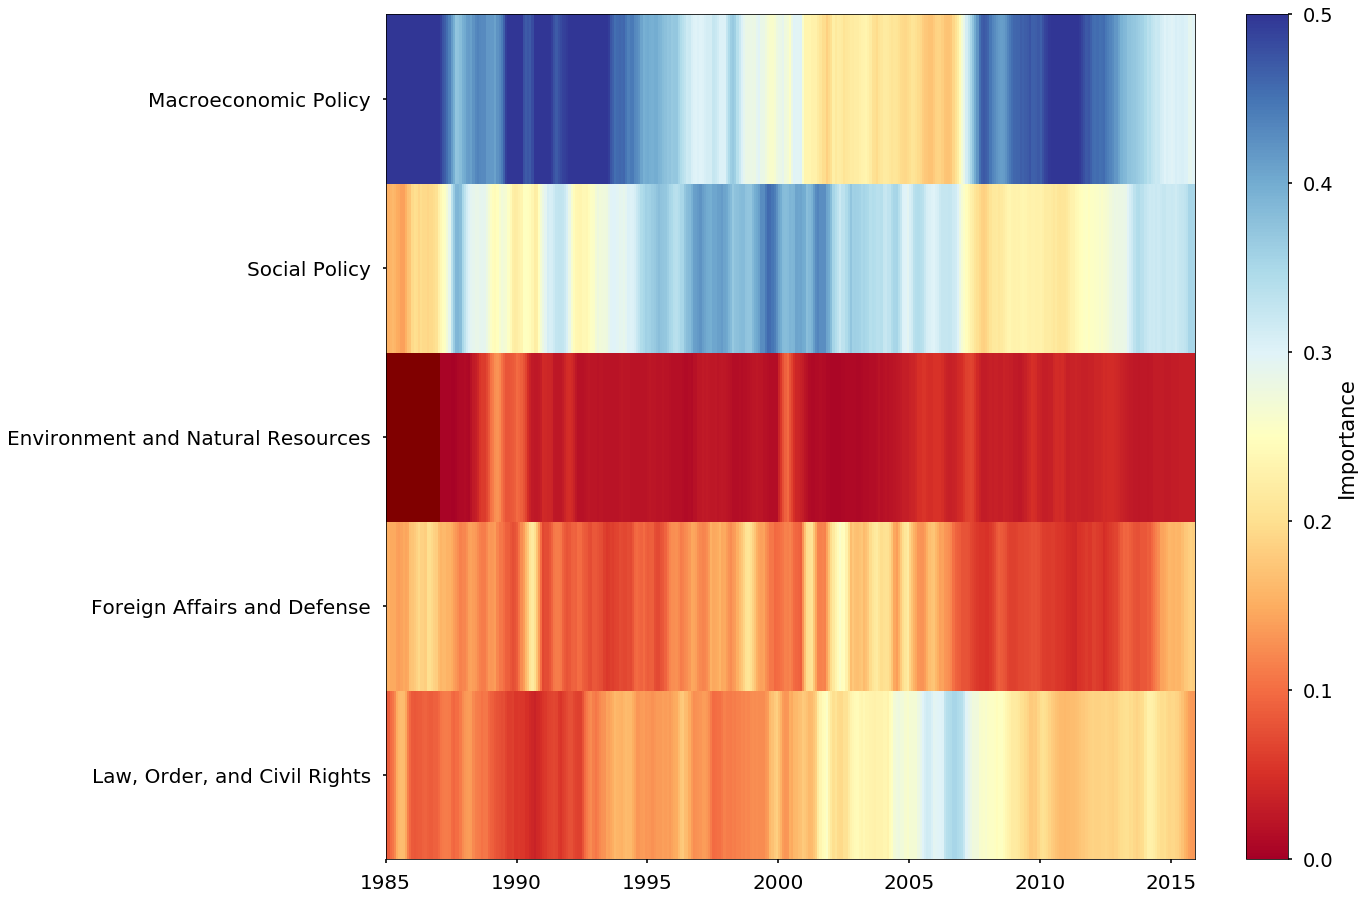

In [108]:
table = table_moving_average
table = table[['Macroeconomic Policy',
               'Social Policy',
               'Environment and Natural Resources',
               'Foreign Affairs and Defense',
               'Law, Order, and Civil Rights',
               'month',
               'year']]

M = table.as_matrix()[:,:-2]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

fig, ax = plt.subplots(1, figsize=(20,13))

Mshow = np.flipud(normM.T)
Mshow[Mshow==0.0] = -1

pc = plt.pcolor(Mshow, cmap='RdYlBu')

#pc.cmap.set_under('rosybrown')
pc.cmap.set_under('maroon')
pc.set_clim(0,0.5)

c = plt.colorbar()
c.set_label('Importance')

keys = month_table.keys()[:-2]
yticks = np.arange(len(keys)-1)+0.5
yticklabels = list(reversed(keys.values[:-1]))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=20)
#ax.set_ylabel('Issues')

xticks = np.arange(0,35*12,5*12)
xticklabels = [ str(i) for i in np.arange(1985,2020,5) ]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=20)
#ax.set_xlabel('Months')

plt.tight_layout()
plt.savefig('images/Superissues-per-month-rolling-mean.png', dpi=200)
plt.show()

## 2 - Make proportion plots

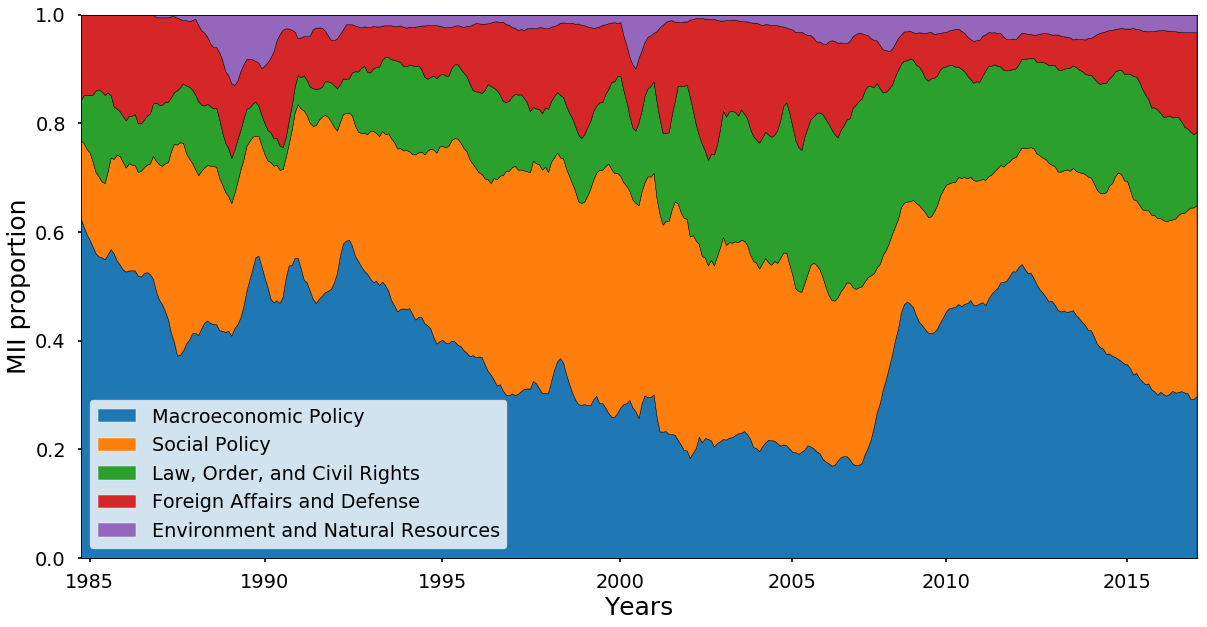

In [109]:
"""
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = plt.cm.get_cmap("tab20c", 600)
colors = [ cmap(np.random.randint(300,600)) if i%2==0 else cmap(np.random.randint(0,300)) for i in range(len(y)) ]
colors = np.random.rand(len(y),3)*0.7 + 0.2
"""

M = table.as_matrix()[:,:-2]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

y = normM.T.astype(float)
x = range(len(y[0]))

n_MIIs = 5

sums = np.array([ sum(i) for i in y ])
index_sort_all = np.argsort(sums)[::-1]
min_sum = sums[index_sort_all][n_MIIs-1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
          #,           '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']*5)[:len(y)]

colors = [ colors[i] if i<n_MIIs else 'lightgrey' for i in range(len(y)) ]

fig, ax = plt.subplots(1, figsize=(20,10))

ax.stackplot(x, y[index_sort_all,:],          colors=colors, edgecolor='whitesmoke')
ax.stackplot(x, y[index_sort_all,:][:n_MIIs], colors=colors, edgecolor='k')

x = np.arange(len(table))
xticklabels = [ m.replace('-',' ') for m in table.month if m[:3]=='Jun' and int(m[-1])%5==0 ]
xticklabels = [ m.replace('Jun ','19') if int(m[4])>=8 else m.replace('Jun ','20') for m in xticklabels ]
xticks = [ x[int(i)] for i,m in enumerate(table.month) if m[:3]=='Jun' and int(m[-1])%5==0  ]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylim(0,1)
ax.set_xlim(0,len(x)-1)

plt.legend(table.keys()[index_sort_all][:n_MIIs], ncol=1, loc=3)
plt.xlabel('Years',fontsize=25)
plt.ylabel('MII proportion',fontsize=25)
plt.savefig('images/Superissues-per-month-rolling-mean-proportions.png', dpi=200)
#plt.savefig('MII-per-month-rolling-mean-proportions.svg', dpi=200)
plt.show()

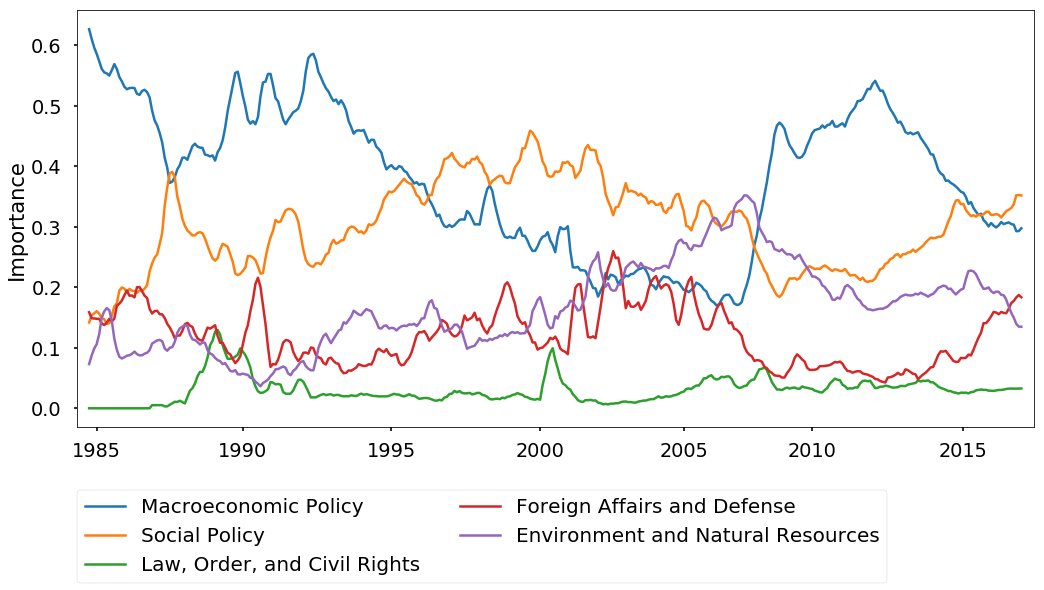

In [110]:
fig, ax = plt.subplots(1,figsize=(15,7))

for i in range(n_MIIs):
    plt.plot(y[i], label=keys[index_sort_all][i], lw=2.5) 

ax.set_ylabel('Importance')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,)
ax.set_xlim(-5+min(x),max(x)+5)

#plt.legend(loc=1, ncol=2)

ax.legend(bbox_to_anchor=(0, -0.15), loc=2, borderaxespad=0.,
          fontsize=20, ncol=2, markerscale=2);


plt.tight_layout()
plt.savefig('images/Superissues-time-series.png', dpi=200)
plt.show()

## What about variance over a rolling window?

In [141]:
# 1 - Make a running mean with a large window
# 2 - With the running mean, make the running variance

N = 10

means_dic = {}
stds_dic = {}
for key in month_table.keys()[:-3]:
    #new_df_dic[key] = running_mean(month_table[key].values, N=N)
    ts = pd.Series(month_table[key].values)
    means_dic[key] = ts.rolling(center=False,window=N).mean()
    stds_dic[key]  = ts.rolling(center=False,window=N).std()

new_df_dic = {}
for key in stds_dic:
    new_df_dic[key] = [ (i,j) for i,j in zip ( means_dic[key], stds_dic[key] )]

#new_df_dic['month'] = month_table['month'].values[int((N-1)/2):-int((N-1)/2)]
#new_df_dic['year']  = month_table['year'].values[int((N-1)/2):-int((N-1)/2)]
    
table_moving_average = pd.DataFrame(new_df_dic)
table_moving_average.tail()

,Environment and Natural Resources,Foreign Affairs and Defense,"Law, Order, and Civil Rights",Macroeconomic Policy,Social Policy
370,"(10.1, 1.074967699773084)","(52.95, 4.7475139693200274)","(56.3, 8.206366092518808)","(97.525, 8.251641250886847)","(104.6, 6.14658893660166)"
371,"(10.2, 1.1595018087283535)","(54.725, 6.12196636892283)","(54.7, 7.409453421136939)","(99.3, 8.42021377400858)","(106.075, 7.312517806246)"
372,"(10.3, 1.13529242439504)","(55.325, 6.200414412673467)","(52.8, 8.024961059095414)","(96.8, 7.095381909696521)","(109.175, 11.556653927499848)"
373,"(10.8, 0.823272602348489)","(57.6, 8.785404562872069)","(52.2, 7.899367063252458)","(99.8, 10.48861816976454)","(113.225, 13.955509664644902)"
374,"(11.1, 1.1737877907772134)","(59.4, 8.554725789488137)","(51.3, 6.848357467305407)","(102.9, 12.688139693780652)","(115.975, 15.292722488527284)"


In [163]:
table = month_table
x = [ datetime.strptime(m.replace('Sept','Sep').replace('General Election 1 April 1997','Apr-97'), '%b-%y')  \
      for m in table.month.values ]
time = [ s.year + s.month*1.0/12 for s in x ]

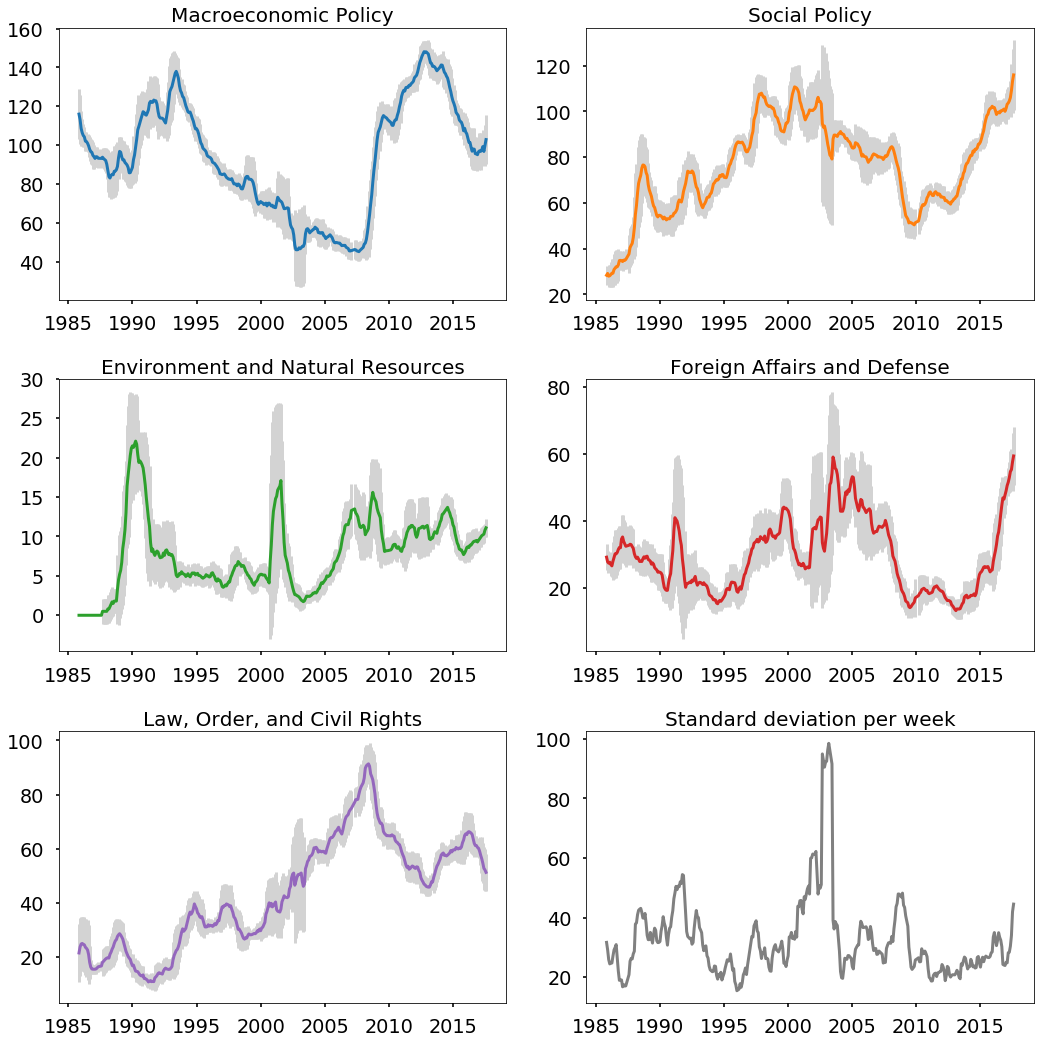

In [187]:
table = table_moving_average
table = table[['Macroeconomic Policy',
               'Social Policy',
               'Environment and Natural Resources',
               'Foreign Affairs and Defense',
               'Law, Order, and Civil Rights']]
keys = table.keys()

M = table.as_matrix()

fig, axs = plt.subplots(3,2, figsize=(15,15))
axs = axs.flatten()
#axs[-1].axis('off')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for key, ax, c in zip(keys[:5], axs[:5], colors):

    y    = [ i[0] for i in table[key].values ]
    yerr = [ i[1] for i in table[key].values ]
    x    = time
    ax.errorbar(x,y,yerr=yerr, color=c, ecolor='lightgray')
    ax.set_title(key, fontsize=20)

    
ax = axs[-1]    
stds_per_week = [ sum([ mij[1] for mij in m_week ]) for m_week in M ]

y    = stds_per_week
x    = time
ax.plot(x,y,'grey')
ax.set_title('Standard deviation per week', fontsize=20);
    
plt.tight_layout()
plt.savefig('images/Superissues-std-time-series.png', dpi=200)
plt.show()

# Other pieces of code
Nothing from this point onwards was super useful.

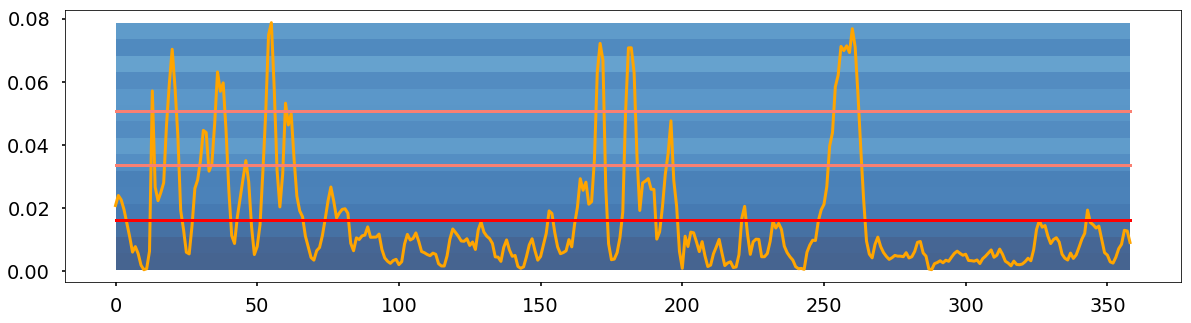

In [54]:
z = KLs_faz_True[ep]
L = len(z)

from sklearn.utils import resample

z2 = resample(z, n_samples=1000000, random_state=i)

cm = plt.cm.Blues
counts, bins = np.histogram(z2, bins=15)
sumcounts = sum(counts)
counts = np.array([ np.log10((i+1)) for i in counts])
colours = np.array([ cm(i/max(counts)) for i in counts])

fig, ax = plt.subplots(1,figsize=(20,5))

ax.plot(z, c='orange')
ax.plot(range(L), [np.mean(z2)]*L, c='red')
ax.plot(range(L), [np.mean(z2) +   np.std(z2)]*L, c='salmon')
ax.plot(range(L), [np.mean(z2) + 2*np.std(z2)]*L, c='salmon')

bottoms = bins[:-1]
tops    = bins[1:]

for b,t,c in zip(bottoms, tops, colours):
    ax.fill_between( range(L), [b]*L, [t]*L, facecolor=c, alpha=0.75)

## Coherence measures

Defining coherence as the average distance between points in a set (say, a year),
- calculate the coherence of every year,
- and the rolling mean coherence of every 3- and 6-months block
- also measure the mean distance between all months in a block/year and the months in the previous adjacent block, to talk about how far a block has gone.

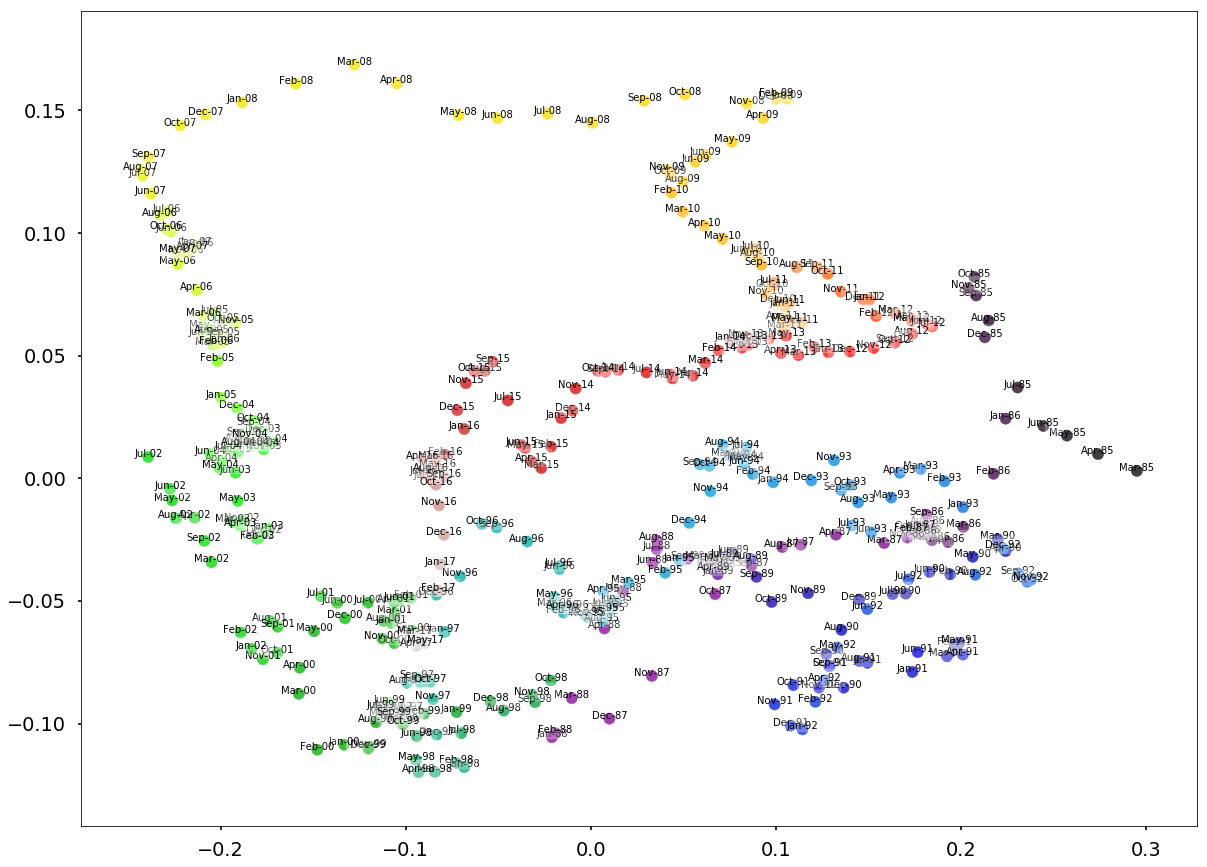

In [59]:
from sklearn import decomposition

centers = [[1, 1], [-1, -1], [1, -1]]
X = normM
Y = np.arange(len(X))

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

cmap = plt.cm.spectral

fig, ax = plt.subplots(1, figsize=(20,15))

ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap)# , edgecolor='k')

dates = table.month.values

for xy,month in zip(X,dates):
    x,y = xy
    ax.text(x,y, month,
          horizontalalignment='center', fontsize=10,
          bbox=dict(alpha=.25, edgecolor='w', facecolor='w'))


plt.show()

In [60]:
def decoherence1(xs,metric='euclidean',ep=0.01, faz=True):
    total_coh = 0
    for p in xs:
        for q in xs:
            total_coh += novelty(p,q,metric=metric,ep=ep,faz=faz)
    return total_coh

def decoherence2(xs,ys,metric='euclidean',ep=0.01, faz=True):
    total_coh = 0
    for p in xs:
        for q in ys:
            total_coh += novelty(p,q,metric=metric,ep=ep,faz=faz)
    return total_coh

In [61]:
blocks_1year_x = []
blocks_1year_y = []
years = list(set(month_table.year))
for year in years:
    df = month_table[month_table.year==year]
    #blocks_1year_y += [ df.as_matrix()[:,:-3] ]
    blocks_1year_y += [ [i/sum(i) if sum(i)>0 else i*0 for i in df.as_matrix()[:,:-3] ] ]
    
    blocks_1year_x += [ year ]

all_N        = [ 1 ]
all_blocks_x = [ blocks_1year_x ]
all_blocks_y = [ blocks_1year_y ]

for N in [3,6]:
    dic_running_mean = { key:running_mean(month_table[key].values, N=N) for key in month_table.keys()[:-3] }
    M = pd.DataFrame(dic_running_mean).as_matrix()
    blocks_x = []
    blocks_y = []
    #for idx in np.arange(0, len(dic_running_mean[keys[0]])-N, N):
    for idx in range(len(dic_running_mean[keys[0]])):
        blocks_x += [ float(month_table.year.values[idx]) + (1.0/12)*float(month_table.date.values[idx][5:7]) ]
        blocks_y += [ [i/sum(i) for i in M[idx:idx+N]] ]
        
    all_blocks_x += [ blocks_x ]
    all_blocks_y += [ blocks_y ]
    all_N        += [ N ]

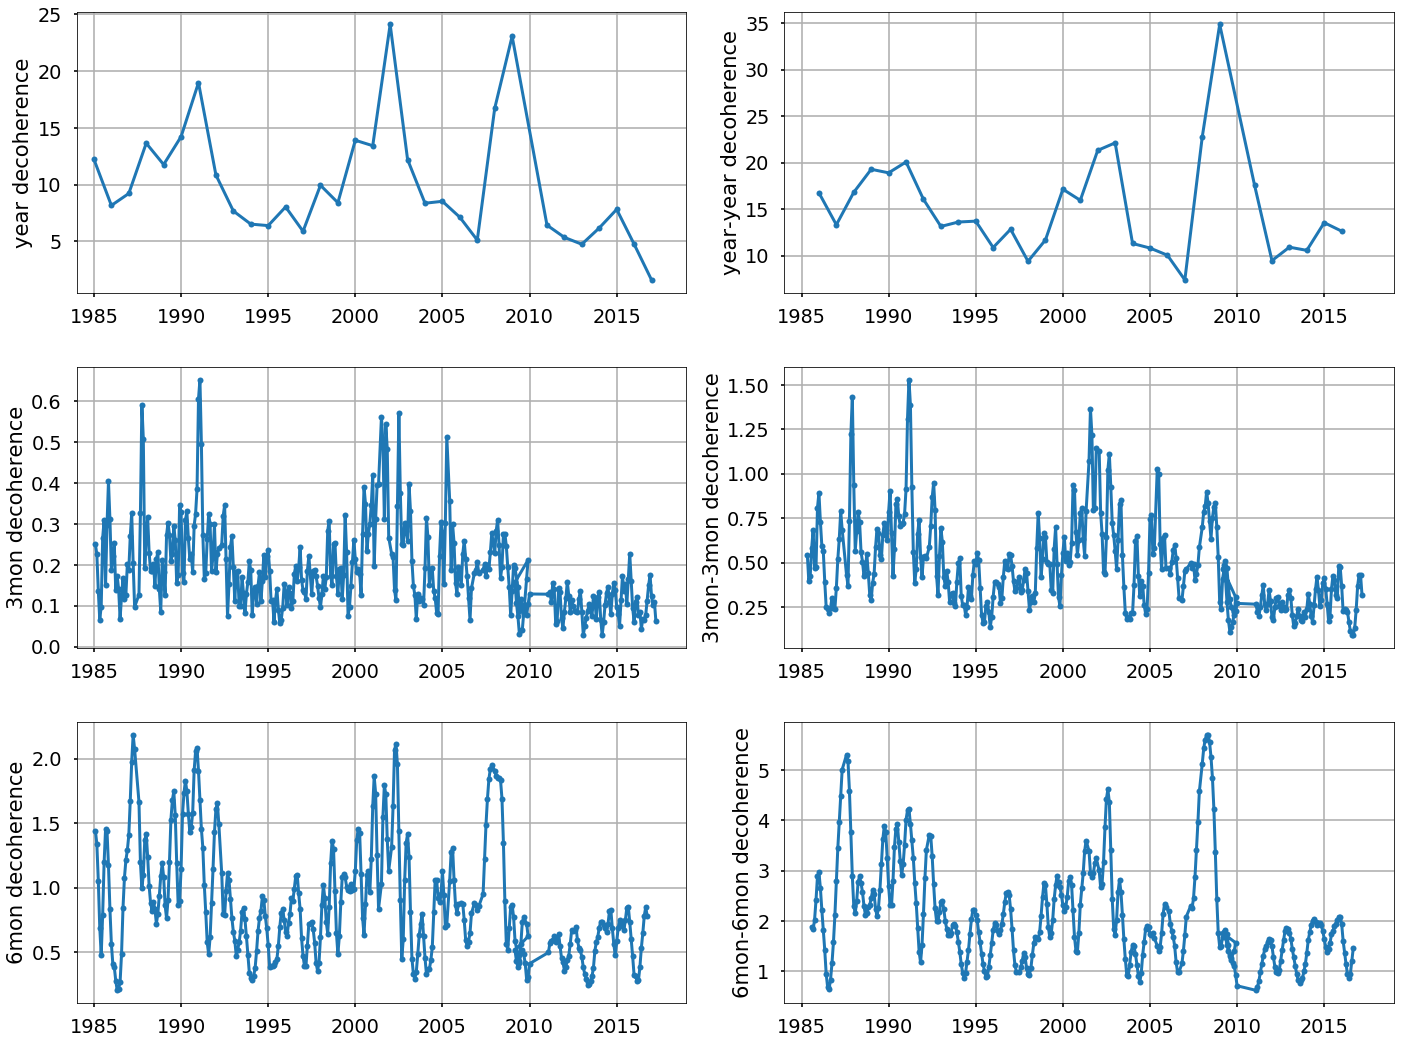

In [62]:
metric = 'euclidean'

dec_1 = [[ decoherence1(xs, metric=metric) for xs in blocks ] for blocks in all_blocks_y]
dec_2 = [[ decoherence2(blocks[i], blocks[i-N], metric=metric) for i in range(1,len(blocks)) ] \
                                                                        for blocks,N in zip(all_blocks_y,all_N) ]

xs = []
ys = []
for i1, i2, x12, N in zip(dec_1, dec_2, all_blocks_x, all_N):
    ys += [ i1[:len(i1)-(N-1)], i2[(N-1):-N] ]
    xs += [ x12[:len(x12)-(N-1)], x12[N:-N] ]

    
ylabels = [
            'year decoherence', 'year-year decoherence',
            '3mon decoherence', '3mon-3mon decoherence',
            '6mon decoherence', '6mon-6mon decoherence'
          ]
#ylims   = [ (0,10000) ]*2 + [ (0,330) ]*2 + [ (0,1800) ]*2 
ylims   = [ (0,35) ]*2 + [ (0,1.75) ]*2 + [ (0,6) ]*2 

fig, axs = plt.subplots(3,2,figsize=(20,15))
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1] ]

for ax,x,y,ylabel,ylim in zip(axs,xs,ys,ylabels,ylims):
    ax.grid()
    ax.plot(x, y, '.-', ms=12)
    ax.set_ylabel(ylabel)
    #ax.set_ylim(ylim)
    ax.set_xlim(1984,2019)
    
plt.tight_layout()
plt.show()

## Rank

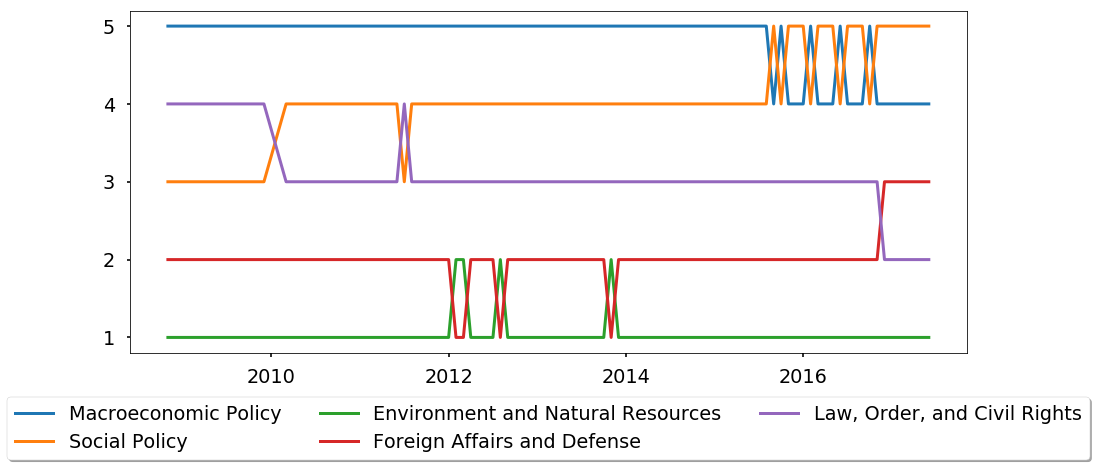

In [136]:
n_MIIs = 5

keys = month_table.keys()[:-3]
selected_keys = keys

selected_indices = np.array([ np.where(keys==k)[0][0] for k in selected_keys ])

M = month_table.as_matrix()[:,:-3]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)

ranks = np.array([ pd.Series(m).rank().values for m in normM ])

for i in range(normM.shape[0]):
    for j in range(normM.shape[1]):
        if normM[i,j] == 0:
            ranks[i,j] = 0

#yticks = np.arange(len(keys.values[selected_indices]))+0.5
#yticklabels = list(keys.values[::-1][selected_indices])
#yticklabels = [ MII_names[key] for key in yticklabels ][::-1]

window = 100
#window = 400

fig, ax = plt.subplots(1,figsize=(15,7))

x = [ datetime.strptime(m.replace('Sept','Sep').replace('General Election 1 April 1997','Apr-97'), '%b-%y')  \
      for m in table.month.values ]
x = [ s.year + s.month*1.0/12 for s in x ]

#x = np.arange(len(table))
#xticklabels = [ m.replace('-',' ') for m in table.month if m[:3]=='Jun' and int(m[-1])%5==0 ]
#xticklabels = [ m.replace('Jun ','19') if int(m[4])>=8 else m.replace('Jun ','20') for m in xticklabels ]
#xticks = [ x[int(i)] for i,m in enumerate(table.month) if m[:3]=='Jun' and int(m[-1])%5==0  ]


#for i in selected_indices:
for i in range(len(selected_indices)):
    plt.plot(x[-window:],ranks[-window:,i], label=keys[selected_indices][i])   

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),   fancybox=True, shadow=True, ncol=3)

plt.savefig('images/Superissues_rank_dynamics.png',dpi=200, bbox_inches='tight')
plt.show()

In [65]:
# Make plot that Helen wants

M = table.as_matrix()[:,:-2]

normM = []
for m in M:
    if sum(m)>0:
        normM += [ list(m/sum(m)) ]
    else:
        normM += [ list(m) ]
normM = np.array(normM)


"""
ten_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

colors = ['lightgrey']*len(y)

for i,idx in enumerate(selected_indices[:10]):
    colors[idx] = ten_colors[i]
    #print("Painting colors",idx,"of",ten_colors[i],":",keys[idx])
    
   
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = plt.cm.get_cmap("tab20c", 600)
colors = [ cmap(np.random.randint(300,600)) if i%2==0 else cmap(np.random.randint(0,300)) for i in range(len(y)) ]
"""
colors = (['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
           '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']*5)[:len(y)]

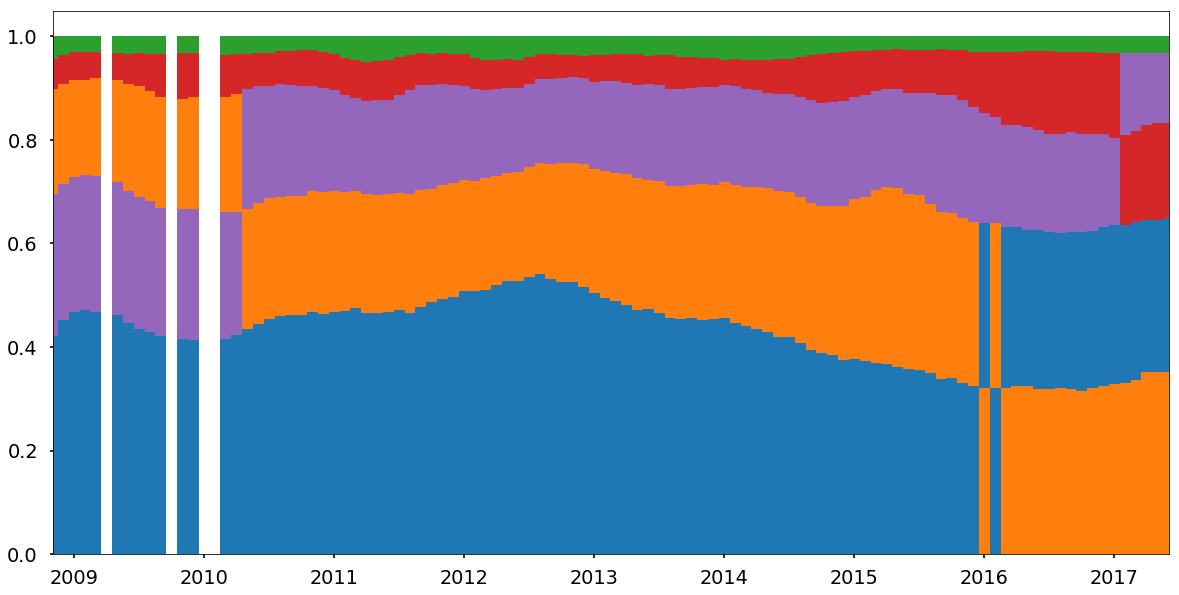

In [66]:
fig, ax = plt.subplots(1,figsize=(20,10))

window = 100
for timestep in range(len(normM)-window,len(normM)):
    value_colors = [ (i,j) for i,j in zip(normM[timestep],colors) ]
    heights_colors  = sorted( value_colors, key=lambda x:-x[0] )
    prev_bottom = 0
    for height, color in heights_colors:
        ax.bar(x[timestep], height, bottom=prev_bottom, color=color, width=0.084) 
        prev_bottom += height
            
ax.set_xlim(min(x[-window:]),max(x[-window:]))
#plt.savefig('images/ordered_proportions.png',dpi=200)
plt.show()

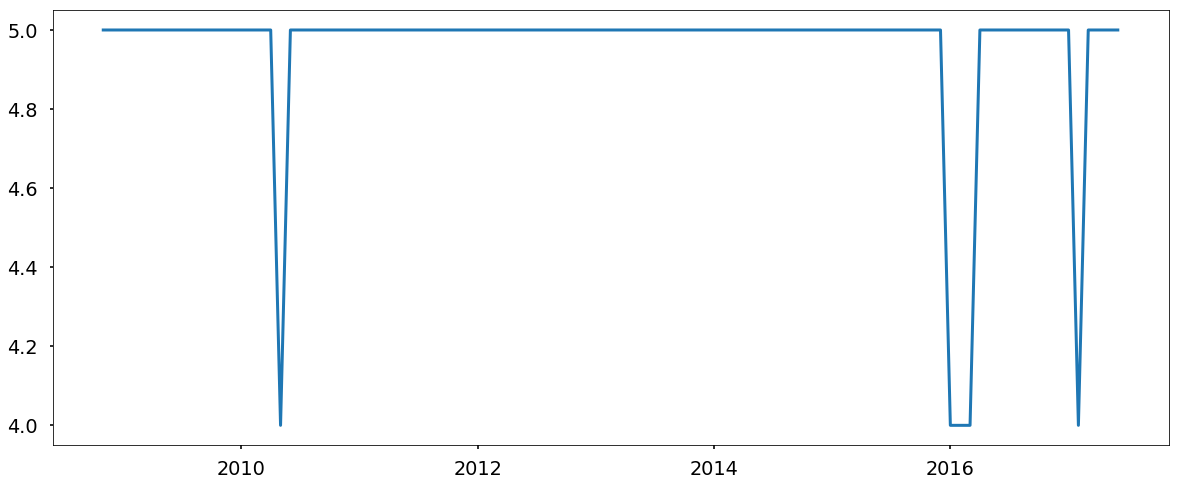

In [67]:
# https://en.wikipedia.org/wiki/Kendall_tau_distance
# https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient
    
from scipy.stats import kendalltau

taus = []
ps   = []
for Mi,Mj in zip(M[:-1], M[1:]):
    tau, p = kendalltau(Mi,Mj)
    taus += [ tau*(len(Mi)) ]
    ps   += [p]
    
plt.figure(figsize=(20,8))
#plt.plot(x[1:], taus)
plt.plot(x[-window:], taus[-window:])
plt.show()

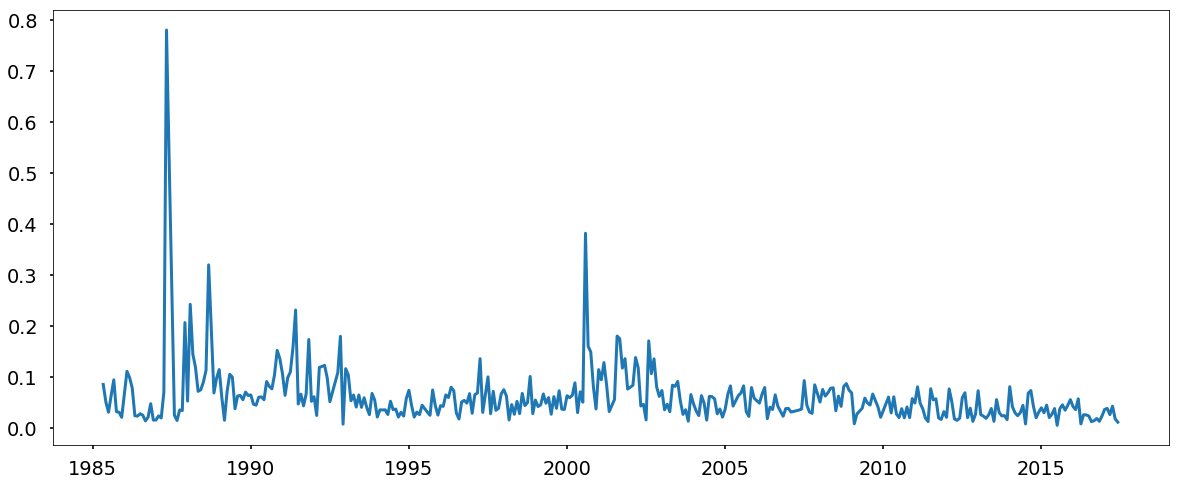

In [68]:
stds = []

for Mi,Mj in zip(M[:-1], M[1:]):
    s    = (Mi+Mj)/2
    #s    = [ max(i,j) for i,j in zip(Mi,Mj) ]
    diff = (Mi-Mj)
    std = np.std([ i/j if j!=0 else 0 for i,j in zip(diff,s)])
    
    #std = np.std([ (i-j)/i for i,j in zip(Mi,Mj) if i*j!=0 ])
    
    stds += [ std ]
    
plt.figure(figsize=(20,8))
plt.plot(x[1:], stds)
#plt.plot(x[-window:], stds[-window:])
plt.show()